
# Lending Club Case Study

## Introduction
This notebook provides an overview of the project, including data analysis, visualizations, and results.

## 1. Data Loading and Preprocessing

## 2. Exploratory Data Analysis (EDA)

## 3. Model Building and Evaluation

In [548]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('future.no_silent_downcasting', True)
%matplotlib inline

In [549]:
loan_data = pd.read_csv('loan.csv', low_memory=False)

In [550]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [551]:
loan_data.shape

(39717, 111)

In [552]:
100*loan_data.isnull().mean()

id                              0.000000
member_id                       0.000000
loan_amnt                       0.000000
funded_amnt                     0.000000
funded_amnt_inv                 0.000000
                                 ...    
tax_liens                       0.098195
tot_hi_cred_lim               100.000000
total_bal_ex_mort             100.000000
total_bc_limit                100.000000
total_il_high_credit_limit    100.000000
Length: 111, dtype: float64

In [553]:
# Dropping columns with all empty values
loan_data.dropna(axis = 1, inplace = True, how = 'all')

# Dropping coulumns which are insignificant and with maximum null data
loan_data.drop(columns=['id','member_id','desc','url','title', 'zip_code','mths_since_last_delinq','mths_since_last_record','next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d'],inplace=True)

# Dropping columns with unique sigle values
nunique = loan_data.nunique()
cols_to_drop = nunique[nunique == 1].index
loan_data.drop(cols_to_drop, axis=1,inplace=True)

# Dropping rows which are not required for problem statement
loan_data = loan_data[loan_data.loan_status != 'Current']

loan_data.shape

(38577, 37)

In [554]:
# Converting Percentage values to float values

loan_data.int_rate = loan_data.int_rate.apply(lambda x : float(x.replace('%','')))
loan_data.revol_util = loan_data.revol_util.apply(lambda x : float(str(x).replace('%','')))

def correct_years_beyond_1969(dt):
    current_year = pd.to_datetime('now').year
    if dt.year > current_year:
        dt = dt.replace(year=dt.year-100)
    return dt

current_year = pd.to_datetime('now').year
loan_data.issue_d = pd.to_datetime(loan_data.issue_d, format='%b-%y').apply(lambda x : correct_years_beyond_1969(x))
loan_data.earliest_cr_line = pd.to_datetime(loan_data.earliest_cr_line,format='%b-%y').apply(lambda x : correct_years_beyond_1969(x))

emp_length_dict = {
    '< 1 year' : 0,
    '1 year' : 1,
    '2 years' : 2,
    '3 years' : 3,
    '4 years' : 4,
    '5 years' : 5,
    '6 years' : 6,
    '7 years' : 7,
    '8 years' : 8,
    '9 years' : 9,
    '10+ years' : 10
}

loan_data = loan_data.replace({"emp_length": emp_length_dict })
loan_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,171.62,0.0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,0,...,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,649.91,0.0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,0.0
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3,...,0.0,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,161.03,0.0


In [555]:
100*loan_data.isnull().mean()

loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
term                       0.000000
int_rate                   0.000000
installment                0.000000
grade                      0.000000
sub_grade                  0.000000
emp_title                  6.185033
emp_length                 2.677761
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
issue_d                    0.000000
loan_status                0.000000
purpose                    0.000000
addr_state                 0.000000
dti                        0.000000
delinq_2yrs                0.000000
earliest_cr_line           0.000000
inq_last_6mths             0.000000
open_acc                   0.000000
pub_rec                    0.000000
revol_bal                  0.000000
revol_util                 0.129611
total_acc                  0.000000
out_prncp                  0.000000
out_prncp_inv              0

In [556]:
# Imputing Missing values for revol_util with mean
loan_data['revol_util'] = loan_data['revol_util'].fillna(loan_data['revol_util'].mean())
loan_data['pub_rec_bankruptcies'] = loan_data['pub_rec_bankruptcies'].fillna(loan_data['pub_rec_bankruptcies'].median())
loan_data['emp_length'] = loan_data['emp_length'].fillna('Missing Year')


In [557]:
100*loan_data.isnull().mean()

loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
term                       0.000000
int_rate                   0.000000
installment                0.000000
grade                      0.000000
sub_grade                  0.000000
emp_title                  6.185033
emp_length                 0.000000
home_ownership             0.000000
annual_inc                 0.000000
verification_status        0.000000
issue_d                    0.000000
loan_status                0.000000
purpose                    0.000000
addr_state                 0.000000
dti                        0.000000
delinq_2yrs                0.000000
earliest_cr_line           0.000000
inq_last_6mths             0.000000
open_acc                   0.000000
pub_rec                    0.000000
revol_bal                  0.000000
revol_util                 0.000000
total_acc                  0.000000
out_prncp                  0.000000
out_prncp_inv              0

<Axes: ylabel='annual_inc'>

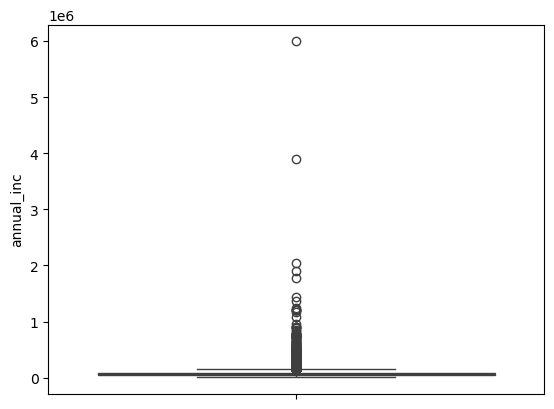

In [558]:
sns.boxplot(loan_data['annual_inc'])

<Axes: ylabel='annual_inc'>

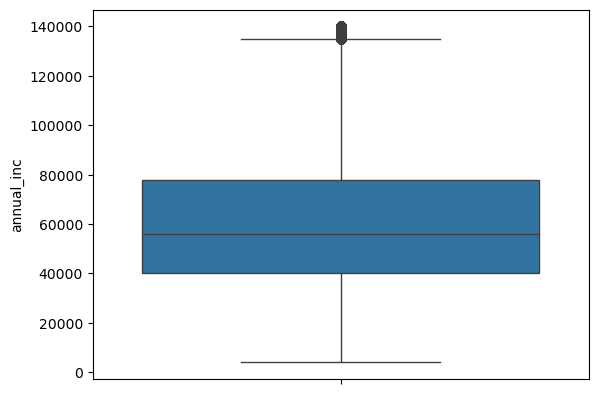

In [559]:
# Removing Outliers

per_95_annual_inc = loan_data['annual_inc'].quantile(0.95)
loan_data = loan_data[loan_data.annual_inc <= per_95_annual_inc]
sns.boxplot(loan_data['annual_inc'])

In [560]:
# One value in below category heavily skews the variate analysis

loan_data.drop(loan_data[(loan_data.term == ' 60 months') & (loan_data.home_ownership == 'OTHER')].index)
loan_data.drop(loan_data[(loan_data.purpose == 'moving') & (loan_data.home_ownership == 'OTHER')].index)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,171.62,0.0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,0,...,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,649.91,0.0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,0.0
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3,...,0.0,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,161.03,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39711,5000,5000,700.0,36 months,8.70,158.30,B,B1,"A. F. Wolfers, Inc.",5,...,0.0,5698.603286,797.80,5000.00,698.60,0.00,0.00,0.00,159.83,0.0
39712,2500,2500,1075.0,36 months,8.07,78.42,A,A4,FiSite Research,4,...,0.0,2822.969293,1213.88,2500.00,322.97,0.00,0.00,0.00,80.90,0.0
39713,8500,8500,875.0,36 months,10.28,275.38,C,C1,"Squarewave Solutions, Ltd.",3,...,0.0,9913.491822,1020.51,8500.00,1413.49,0.00,0.00,0.00,281.94,0.0
39714,5000,5000,1325.0,36 months,8.07,156.84,A,A4,NaN,0,...,0.0,5272.161128,1397.12,5000.00,272.16,0.00,0.00,0.00,0.00,0.0


In [561]:
# Display Bar Height in Percentage in bar charts
def display_bar_height_in_percent(ax):
    for c in ax.containers:
        #Customize the labels
        labels = [str(v.get_height()) + '%'  if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center')

 # Univariate Analysis

<Axes: ylabel='loan_amnt'>

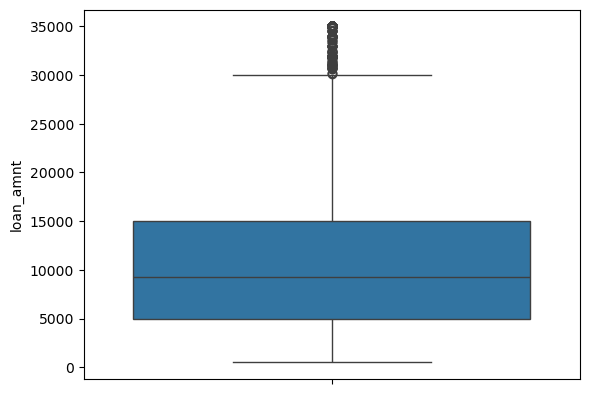

In [563]:
# Univariate analysis on loan_amnt
sns.boxplot(y='loan_amnt',data=loan_data)

<Axes: xlabel='term', ylabel='count'>

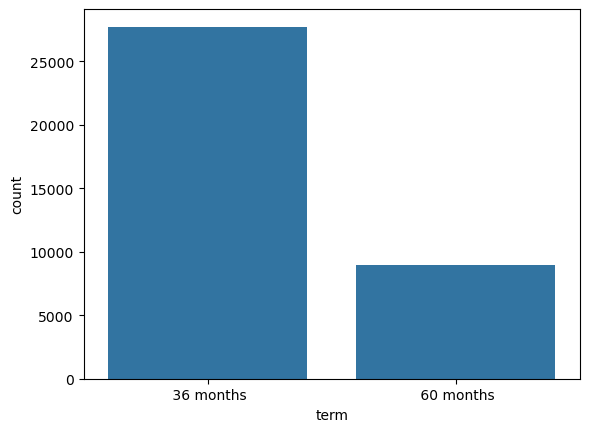

In [564]:
# Univariate analysis on term
sns.countplot(x=loan_data["term"])

<Axes: xlabel='count', ylabel='emp_length'>

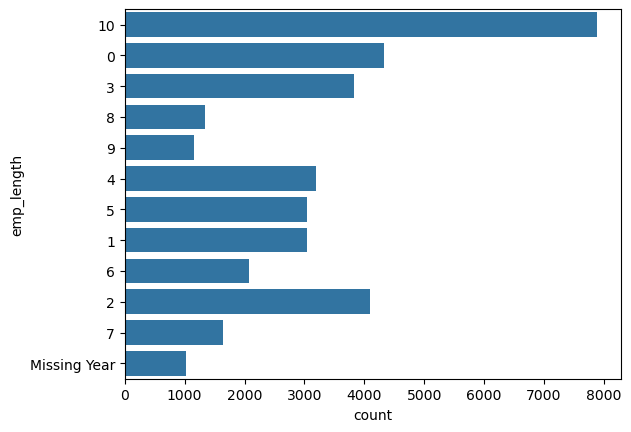

In [565]:
# Univariate analysis on Employment Length
sns.countplot(y=loan_data["emp_length"])

<Axes: xlabel='home_ownership', ylabel='count'>

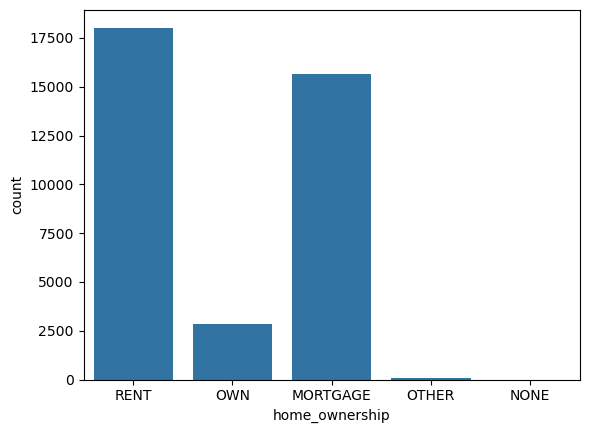

In [566]:
# Univariate analysis on Home Ownership
sns.countplot(x=loan_data["home_ownership"])

<Axes: xlabel='verification_status', ylabel='count'>

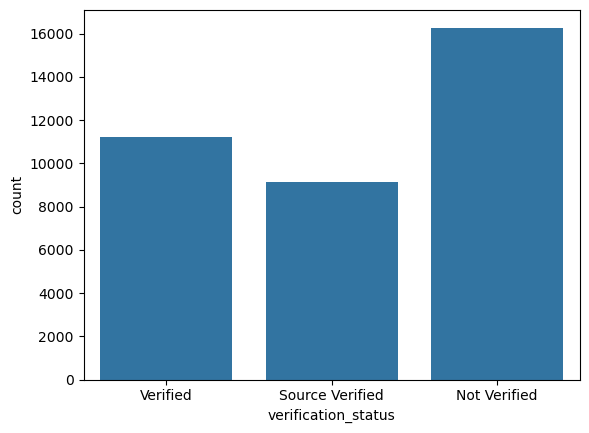

In [567]:
# Univariate analysis on Verification Status
sns.countplot(x=loan_data["verification_status"])

<Axes: xlabel='count', ylabel='purpose'>

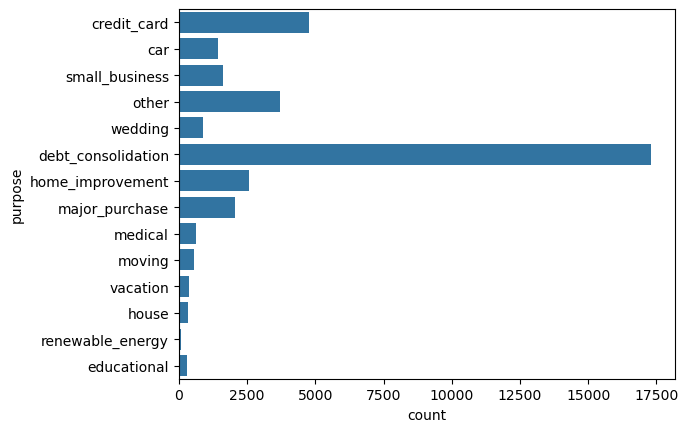

In [568]:
# Univariate analysis on Purpose
sns.countplot(y=loan_data["purpose"])

# Segmented Univariate Analysis

'Loan Applicants with higher Funded Amount tend to default more than that of lower amounts'

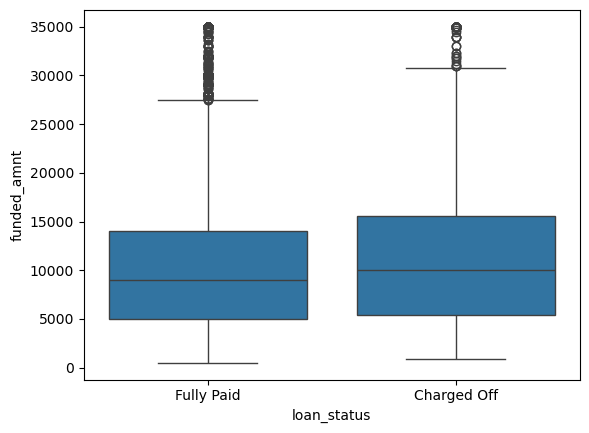

In [570]:
# Segmented Univariate analysis using loan_amnt

sns.boxplot(x='loan_status',y='funded_amnt',data=loan_data)

'Loan Applicants with higher Funded Amount tend to default more than that of lower amounts'

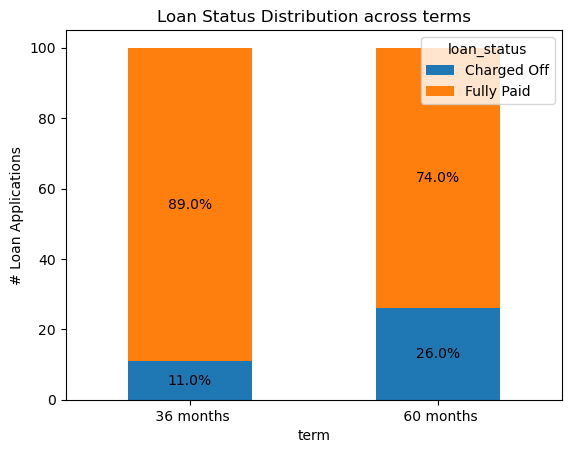

'Loan Applicants with the term 60 months are more likely to default than that of 36 months'

In [571]:
# Segmented Univariate analysis using term

df_grouped = loan_data.groupby(['term','loan_status'])['loan_status'].count().unstack()
ax = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
display_bar_height_in_percent(ax)
plt.xticks(rotation=0)
plt.ylabel('# Loan Applications')
plt.title('Loan Status Distribution across terms')
plt.show()

'Loan Applicants with the term 60 months are more likely to default than that of 36 months'

'Loan Applicants who got loan for higher interest rates are more likely to default than that of lower interest rates'

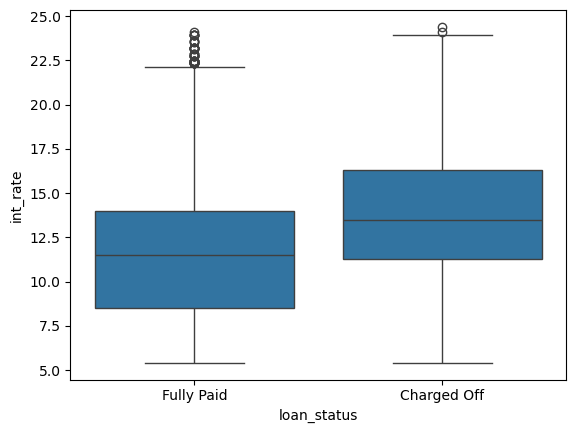

In [572]:
# Segmented Univariate analysis using int_rate

sns.boxplot(x='loan_status',y='int_rate',data=loan_data)

'Loan Applicants who got loan for higher interest rates are more likely to default than that of lower interest rates'

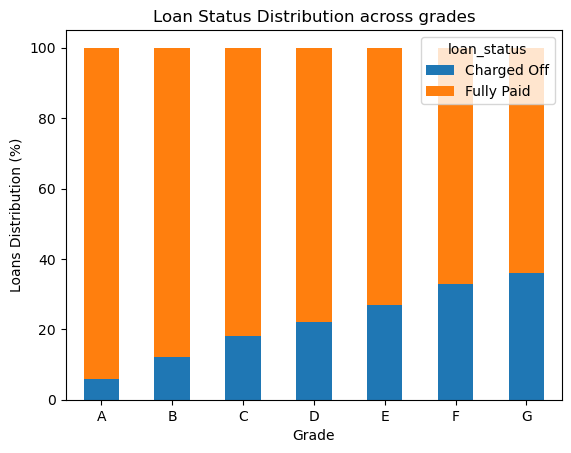

'Loan Applicants with grades E,F,G are more likely to default than that of others. This correlates with interest rates analysis since E,F,G grades has higher interest rates'

In [573]:
# Segmented Univariate analysis using grade

df_grouped = loan_data.groupby(['grade','loan_status'])['loan_status'].count().unstack()
df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Grade')
plt.title('Loan Status Distribution across grades')
plt.show()

'Loan Applicants with grades E,F,G are more likely to default than that of others. This correlates with interest rates analysis since E,F,G grades has higher interest rates'

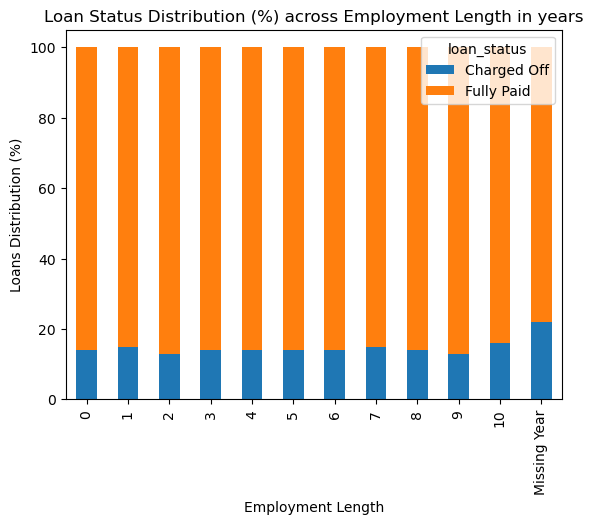

'Loan Applicants with employment length of 10+years and NA tend to default more than others'

In [574]:
# Segmented Univariate analysis using emp_length

df_grouped = loan_data.groupby(['emp_length','loan_status'])['loan_status'].count().unstack()
df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
plt.xticks(rotation=90)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Employment Length')
plt.title('Loan Status Distribution (%) across Employment Length in years')
plt.show()

'Loan Applicants with employment length of 10+years and NA tend to default more than others'

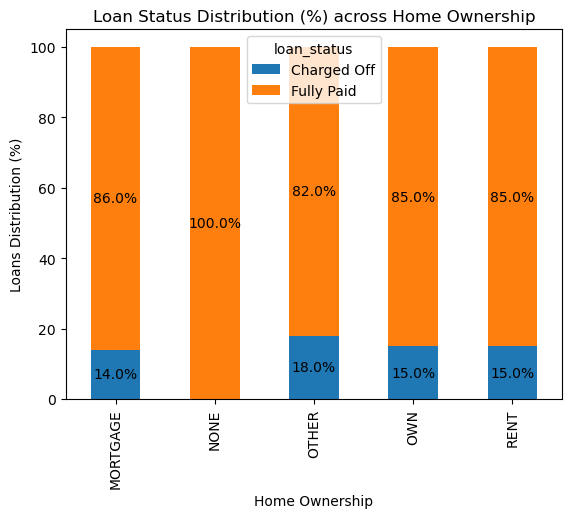

'Applicants with Home Ownership OTHER tend to default more than others. Interesting fact to note that Home Ownership= None has no defaulters.'

In [575]:
# Segmented Univariate analysis using home_ownership

df_grouped = loan_data.groupby(['home_ownership','loan_status'])['loan_status'].count().unstack()
ax = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
display_bar_height_in_percent(ax)
plt.xticks(rotation=90)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Home Ownership')
plt.title('Loan Status Distribution (%) across Home Ownership')
plt.show()

'Applicants with Home Ownership OTHER tend to default more than others. Interesting fact to note that Home Ownership= None has no defaulters.'

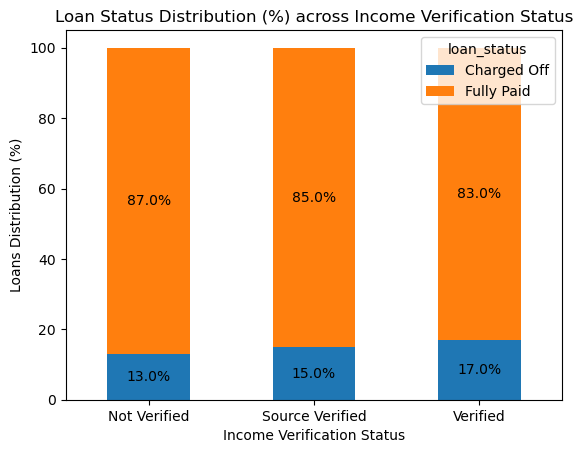

'Surprisingly, Loan Applications whose Income is verified defaults more than others by at least 2%. May be verification process needs to be revisited'

In [576]:
# Segmented Univariate analysis using Income Verification Status

df_grouped = loan_data.groupby(['verification_status','loan_status'])['loan_status'].count().unstack()
ax = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
display_bar_height_in_percent(ax)
plt.xticks(rotation=0)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Income Verification Status')
plt.title('Loan Status Distribution (%) across Income Verification Status')
plt.show()

'Loan Applications whosever Income is verified defaults more than others by <=2%. verification process should be taken care

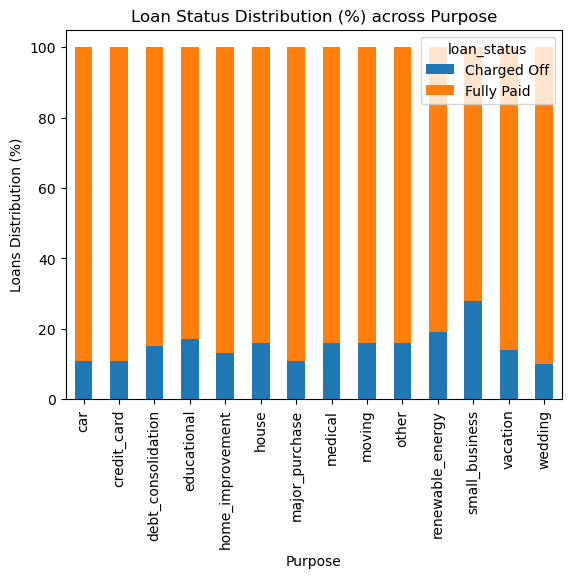

'Loan Applicants for the purpose of Small Business tend to default more than other purposes by a huge difference between 8 % - 17 %'

In [577]:
# Segmented Univariate analysis using purpose

df_grouped = loan_data.groupby(['purpose','loan_status'])['loan_status'].count().unstack()
df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1).plot(kind='bar', stacked=True)
plt.xticks(rotation=90)
plt.ylabel('Loans Distribution (%)')
plt.xlabel('Purpose')
plt.title('Loan Status Distribution (%) across Purpose')
plt.show()

'Loan Applicants for the purpose of Small Business tend to default more than other purposes by a huge difference between 8 % - 17 %'

'Loan Applications with higher revolving credit utilization tend to default the loan than others'

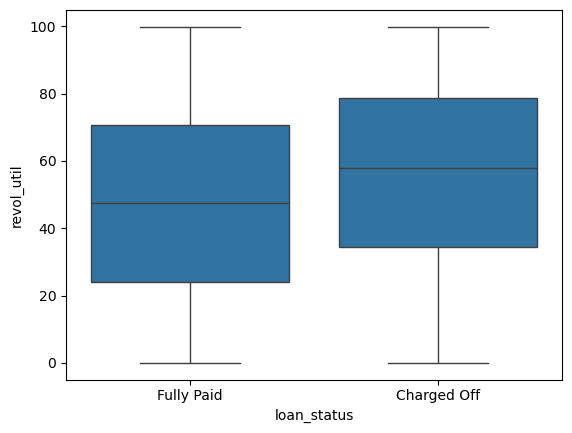

In [578]:
# Segmented Univariate analysis using Revolving Credit Utilization

sns.boxplot(x='loan_status',y='revol_util', data=loan_data)

'Loan Applications with higher revolving credit utilization tend to default the loan than others'

# Bivariate Analysis

'There are very less defaulters when Funded Amount is same as the Loan Amount(linear relation)'

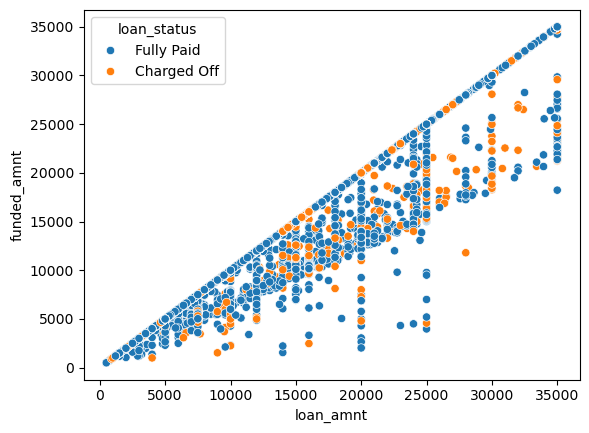

In [580]:
# Bivariate Analysis: Loan Amount vs Funded Amount

sns.scatterplot(x='loan_amnt',y='funded_amnt',data=loan_data,hue='loan_status')

'There are very less defaulters when Funded Amount is same as the Loan Amount(linear relation)'

'Loan Applicants with employment length of 7 years and NA values tend to default more when the term of the loan is 60 months'

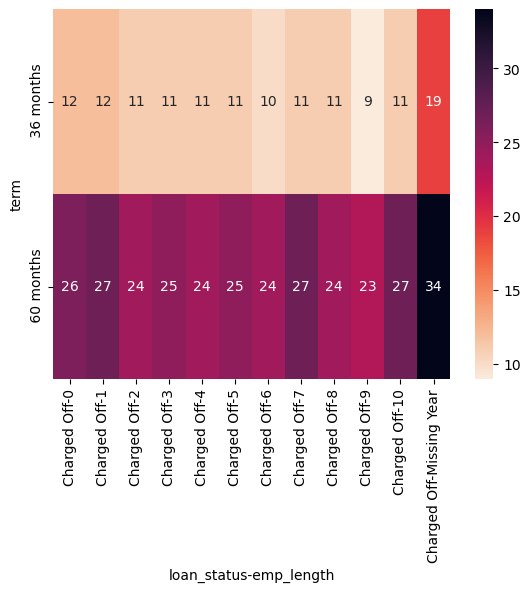

In [581]:
# Bivariate Analysis: Term vs Employment Length

df_grouped = loan_data.groupby(['term','emp_length','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r)

'Loan Applicants with employment length of 7 years and NA values tend to default more when the term of the loan is 60 months'

'Loan Applicants with term as 60 months and Home Ownership as OWN and RENT default more likely'

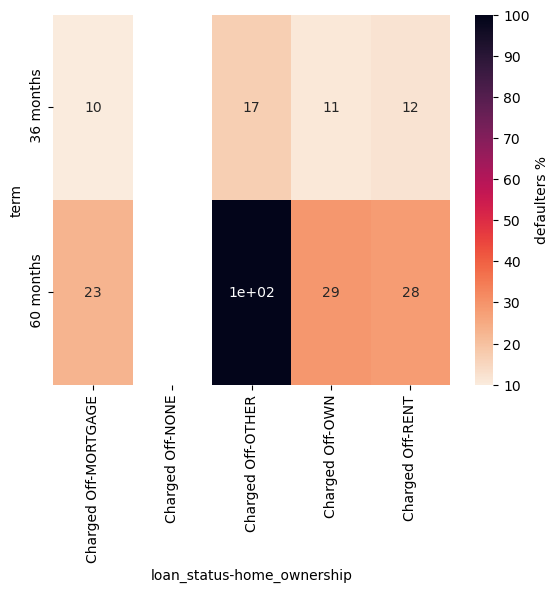

In [582]:
# Bivariate Analysis: Term vs Home Ownership

df_grouped = loan_data.groupby(['term','home_ownership','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r,cbar_kws={'label': 'defaulters %'})

'Loan Applicants with term as 60 months and Home Ownership as OWN and RENT default more likely'

'Loan Applicants for the purpose of small business tend to default more across RENT, OWN and OTHER home ownerships. Also, Car - OTHER combination seem to default likely'

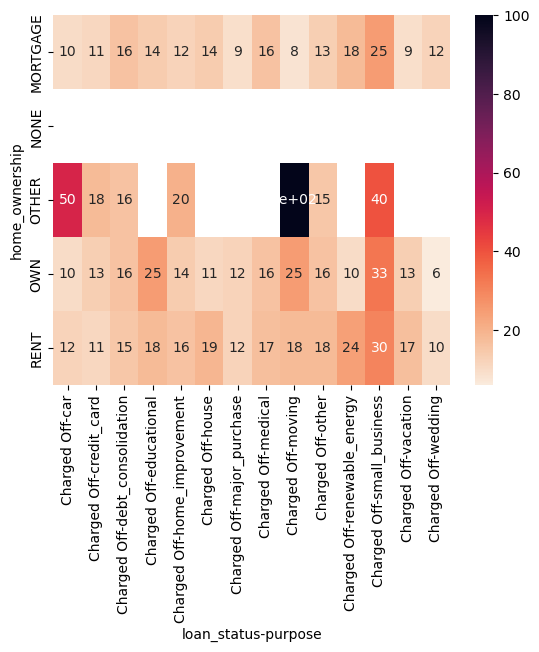

In [583]:
# Bivariate Analysis: Home ownership vs Purpose

df_grouped = loan_data.groupby(['home_ownership','purpose','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r)

'Loan Applicants for the purpose of small business tend to default more across RENT, OWN and OTHER home ownerships. Also, Car - OTHER combination seem to default likely'

'Loan Applicants for purpose as renewable energy tend to likely default when their employment length is 4 years or 8 years. Also, Loan Applicants with no employment length specified tend to default more for educational purpose'

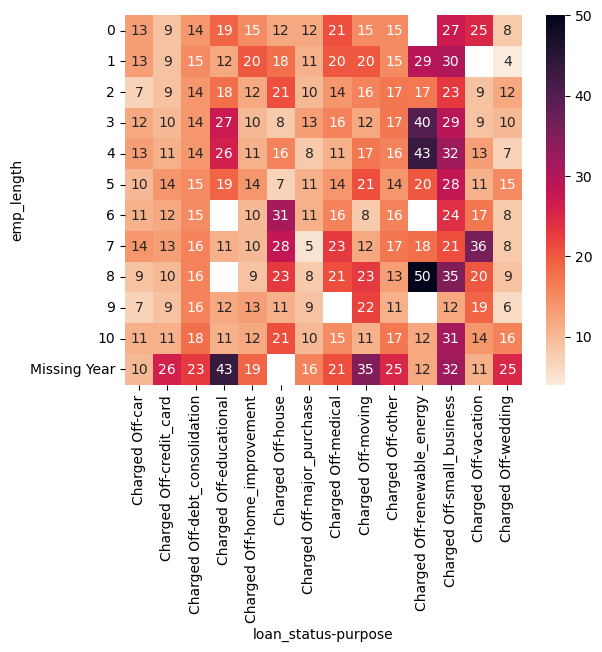

In [584]:
# Bivariate Analysis: Emp Length vs Purpose

df_grouped = loan_data.groupby(['emp_length','purpose','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
sns.heatmap(df_unstacked, annot=True, cmap=sns.cm.rocket_r)

'Loan Applicants for purpose as renewable energy tend to likely default when their employment length is 4 years or 8 years. Also, Loan Applicants with no employment length specified tend to default more for educational purpose'

'Loan Applicants with higher Total Credit Revolving Balance tend to default likely when the term is 60 months'

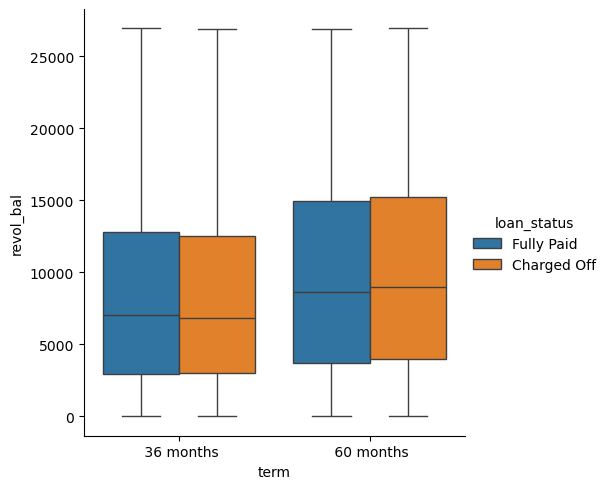

In [585]:
# Bivariate Analysis: Term vs revol_bal

df_filtered = loan_data[loan_data.revol_bal <= loan_data.revol_bal.quantile(0.90)]
sns.catplot(x='term',y='revol_bal',data=df_filtered,hue='loan_status',kind='box')

'Loan Applicants with higher Total Credit Revolving Balance tend to default likely when the term is 60 months'

'Loan Applications with term as 60 months and their income verified and source verified tend to default more likely than others'

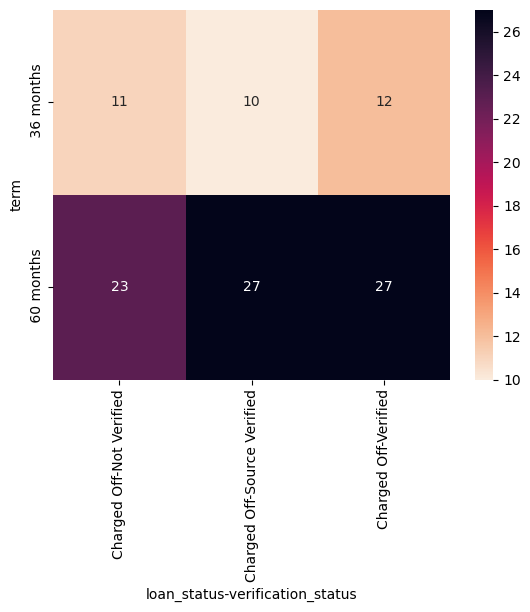

In [586]:
# Bivariate Analysis: Term vs Verification Status

df_grouped = loan_data.groupby(['term','verification_status','loan_status'])['loan_status'].count().unstack()
df_grouped = df_grouped.apply(lambda x : round(x*100/x.sum()),axis=1)
df_grouped.drop(columns='Fully Paid',inplace=True)
df_unstacked = df_grouped.unstack()
sns.heatmap(df_unstacked, annot=True,cmap=sns.cm.rocket_r)

'Loan Applications with term as 60 months and their income verified and source verified tend to default more likely than others'